# 00.2 - K<sub>d</sub>

## Background
00 and 00.1 showed that it was difficult to pick apart signal from background with the one concentration dump-style screen because the control & test (-/+ protein) traces don't cancel cleanly.
Possible causes:

- Compound UV-Vis absorbance - common. 
    - variable well volume - pipette precision
- Scattering
    - DMSO ice
    - compound precipitation
    - protein precipitation
    
$\frac{\delta y}{\delta x}$ of the traces corrects for baseline drift ok.

## Aim
- Test $K_d$ style assay
- Test `echo` package

## Method


In [1]:
import numpy as np
import pandas as pd

df = pd.read_csv('../../../data/lib/layouts.csv',index_col=0)
df.head()

,Item Name,CatalogNumber,SMILES,Rack Number,Plate Location
0,Axitinib,S1005,CNC(=O)C1=CC=CC=C1SC1=CC2=C(C=C1)C(\C=C\C1=CC=...,L1300-01,a1
1,Afatinib (BIBW2992),S1011,CN(C)C\C=C\C(=O)NC1=CC2=C(NC3=CC=C(F)C(Cl)=C3)...,L1300-01,b1
2,Bortezomib (Velcade),S1013,CC(C)C[C@H](NC(=O)[C@H](CC1=CC=CC=C1)NC(=O)C1=...,L1300-01,c1
3,Bosutinib (SKI-606),S1014,COC1=C(Cl)C=C(Cl)C(NC2=C(C=NC3=CC(OCCCN4CCN(C)...,L1300-01,d1
4,Dasatinib (BMS-354825),S1021,CC1=NC(NC2=NC=C(S2)C(=O)NC2=C(Cl)C=CC=C2C)=CC(...,L1300-01,e1


## Mapping 96-384 wells
Using a multichannel pipette

In [2]:
import re
from string import ascii_uppercase
import itertools
import echo


def mapWell384(well, xoff=0, yoff=0):
    '''
    map pipetting from 96 to 384 well plate, 
    given a multi-channel pipette and an offset
    '''
    assert re.search('[a-zA-Z][0-9]+', well) is not None
    let, num = re.search('([a-zA-Z])([0-9]+)', well).groups()
    let = ascii_uppercase[ascii_uppercase.index(let.upper()) * 2 + yoff]
    num = int(((int(num)-1) * 2) + 1 + xoff)
    return f'{let}{num}'


src = echo.SrcPlate(name='2022-03-07-00.2',ldv=True)

rack1 = df.loc[df['Rack Number'] == 'L1300-01',:]

d = {}
cpds = []

for i, j in zip(rack1['Plate Location'], rack1['CatalogNumber']):
    a = mapWell384(i)
    d[i.upper()] = a
    cpd = echo.Cpd(name=j, vol=100)
    src[a].fill(cpd.sample(12))
    cpds.append(cpd)
    
conc_grad = np.linspace(0,1,4)**2 * 1.5

dest1 = echo.Plate(name='test')
dest2 = echo.Plate(name='ctrl')

wells = itertools.chain(echo.hwells)

for i in d:
    for j, k in zip(wells, conc_grad):
        src[d[i]].xfer(dest1[j], k)
        src[d[i]].xfer(dest2[j], k)
            
        
picklist = pd.DataFrame(src.xfer_record).sort_values(['Destination Plate Name','SrcWell'])
picklist = picklist.loc[picklist['Transfer Volume /nl'] != 0., :] # echo doesn't allow 0 nl
picklist.head(n=8)

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl
3,2022-03-07-00.2,[S1005],A1,ctrl,A2,167.5
5,2022-03-07-00.2,[S1005],A1,ctrl,A3,667.5
7,2022-03-07-00.2,[S1005],A1,ctrl,A4,1500.0
43,2022-03-07-00.2,[S1199],A11,ctrl,I10,167.5
45,2022-03-07-00.2,[S1199],A11,ctrl,I11,667.5
47,2022-03-07-00.2,[S1199],A11,ctrl,I12,1500.0
51,2022-03-07-00.2,[S1212],A13,ctrl,K2,167.5
53,2022-03-07-00.2,[S1212],A13,ctrl,K3,667.5


In hindsight I didn't need to split the two plates.
At the time, the echo was ejecting the destination plate immediately, so I thought it was becuase there were >1 plate name in the picklist.
Turns out I had mapped the wells wrong, so it scanned empty wells and then rejected the plate.
I made some corrections and then it seemed to work fine.

In [3]:
d1 = picklist.loc[picklist['Destination Plate Name'] == 'ctrl',:]
d2 = picklist.loc[picklist['Destination Plate Name'] == 'test',:]

In [4]:
d1.to_csv('echo/picklists/2022-03-07-00.2-picklist-ctrl.csv', index=False)
d2.to_csv('echo/picklists/2022-03-07-00.2-picklist-test.csv', index=False)

## Plotting the layouts
This is useful to catch errors early

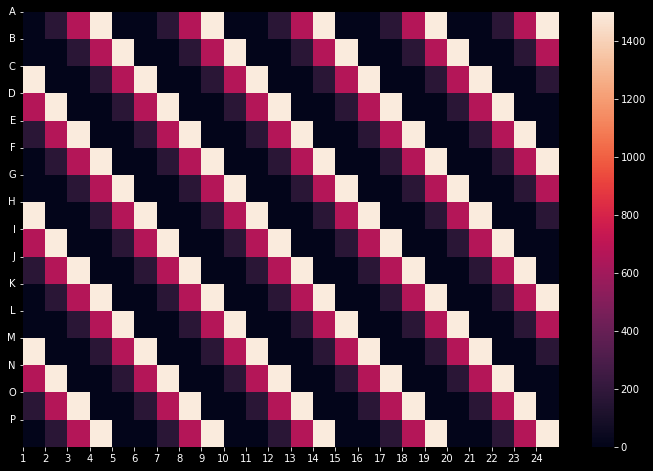

In [5]:
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import seaborn as sns
from string import ascii_lowercase, ascii_uppercase

class WellArr:
    def __init__(self):
        self.x = np.zeros((16,24))
    def __getitem__(self, idx):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            return self.x[i,j]
    def __setitem__(self, idx, new):
        if isinstance(idx, str):
            if idx[0] in ascii_lowercase:
                i = ascii_lowercase.index(idx[0])
            if idx[0] in ascii_uppercase:
                i = ascii_uppercase.index(idx[0])
            j = int(idx[1:]) -1
            self.x[i,j] = new
    def __len__(self):
        return len(self.x.flatten())
    
x = WellArr()

for i, j in zip(picklist.DestWell, 
                picklist['Transfer Volume /nl']):
    x[i] = j

plt.figure(figsize=(12,8))
sns.heatmap(x.x, annot=False)
plt.xticks(range(24), range(1,25))
plt.yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
plt.show()

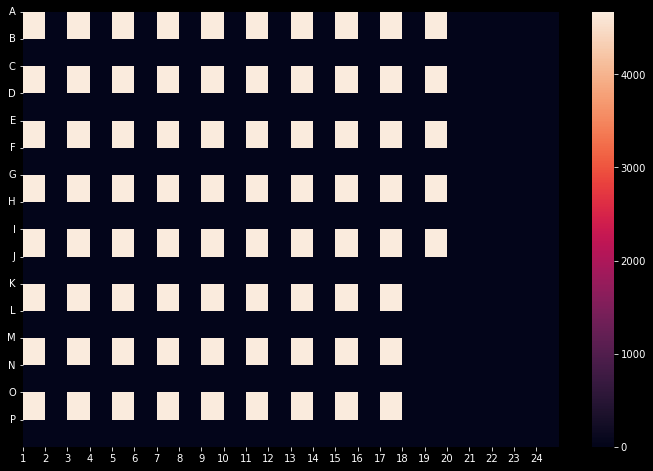

In [6]:
x = WellArr()

d = {}
cpds = []

for i, j in zip(picklist.SrcWell, 
                picklist['Transfer Volume /nl']):
    x[i] += j

plt.figure(figsize=(12,8))
sns.heatmap(x.x, annot=False)
plt.xticks(range(24), range(1,25))
plt.yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
plt.show()

## 2022-03-08  - Hamilton

I think the error in the multichannel pipette when dispensing protein / buffer is messing up the accuracy afforded by the echo.
I used to use a [multidrop](https://www.thermofisher.com/uk/en/home/life-science/lab-equipment/microplate-instruments/multidrop-dispensers.html) for this and it worked really well, but that's gone now.
The only one left is part of the FBRH robot rig, facing inward.  
Mark said I couldn't use it but that he'd set up a [Hamilton](https://www.hamiltoncompany.com/automated-liquid-handling/platforms/microlab-star) script for me.
I'm booked to use it tomorrow (2022-03-09) morning at 8-10.

I dispensed the plates for it this morning.
I added more compound from rack 1 to the source plate, offset one well to the right from where it was.

I guess it's worth noting that the echo dispensing didn't go smoothly to start with.
The destination plates would be ejected immediately after registering a transfer.
I split the ctrl and test picklists and made sure not to import the plate name column.
That seemed to work ok.


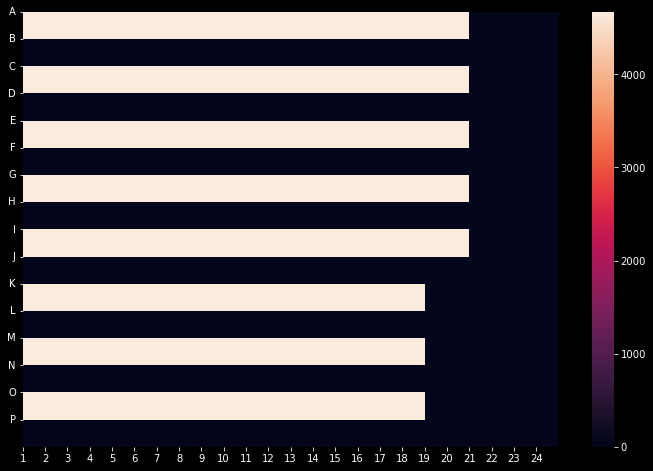

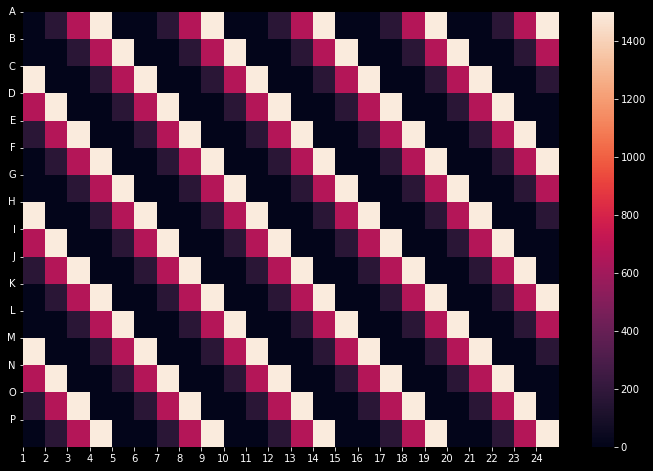

,SrcPlate,Cpd,SrcWell,Destination Plate Name,DestWell,Transfer Volume /nl
3,2022-03-07-00.2,[S1005],A1,ctrl,A2,167.5
5,2022-03-07-00.2,[S1005],A1,ctrl,A3,667.5
7,2022-03-07-00.2,[S1005],A1,ctrl,A4,1500.0
75,2022-03-07-00.2,[S1188],A10,ctrl,G18,167.5
77,2022-03-07-00.2,[S1188],A10,ctrl,G19,667.5
79,2022-03-07-00.2,[S1188],A10,ctrl,G20,1500.0
83,2022-03-07-00.2,[S1199],A11,ctrl,I10,167.5
85,2022-03-07-00.2,[S1199],A11,ctrl,I11,667.5


In [7]:
d = {}

for i, j in zip(rack1['Plate Location'], rack1['CatalogNumber']):
    a = mapWell384(i, xoff=1)
    cpd = echo.Cpd(name=j, vol=100)
    src[a].fill(cpd.sample(12))
    d[a] = cpd
    
conc_grad = np.linspace(0,1,4)**2 * 1.5

dest1 = echo.Plate(name='test')
dest2 = echo.Plate(name='ctrl')

wells = itertools.chain(echo.hwells)

for i in d:
    for j, k in zip(wells, conc_grad):
        src[i].xfer(dest1[j], k)
        src[i].xfer(dest2[j], k)
            

picklist2 = pd.DataFrame(src.xfer_record).sort_values(['Destination Plate Name','SrcWell'])
picklist2 = picklist2.loc[picklist2['Transfer Volume /nl'] != 0., :] # echo doesn't allow 0 nl
            
x = WellArr()
for i, j in zip(picklist2.SrcWell, 
                picklist2['Transfer Volume /nl']):
    x[i] += j

plt.figure(figsize=(12,8))
sns.heatmap(x.x, annot=False)
plt.xticks(range(24), range(1,25))
plt.yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
plt.show()
    
x = WellArr()
for i, j in zip(picklist2.DestWell, 
                picklist2['Transfer Volume /nl']):
    x[i] = j

plt.figure(figsize=(12,8))
sns.heatmap(x.x, annot=False)
plt.xticks(range(24), range(1,25))
plt.yticks(range(16), list(ascii_uppercase)[:16], rotation=0)
plt.show()

picklist2.head(n=8)

In [8]:
picklist2_ctrl = picklist2.loc[picklist2['Destination Plate Name']=='ctrl',:]
picklist2_test = picklist2.loc[picklist2['Destination Plate Name']=='test',:]

In [9]:
ls echo/picklists

2022-03-07-00.2-picklist-ctrl.csv  2022-03-08-00.2-picklist-ctrl.csv
2022-03-07-00.2-picklist-test.csv  2022-03-08-00.2-picklist-test.csv
2022-03-08-00.2-picklist.csv


In [10]:
picklist2.to_csv('echo/picklists/2022-03-08-00.2-picklist.csv',index=False)
picklist2_ctrl.to_csv('echo/picklists/2022-03-08-00.2-picklist-ctrl.csv',index=False)
picklist2_test.to_csv('echo/picklists/2022-03-08-00.2-picklist-test.csv',index=False)

`echo/picklists/2022-03-08-00.2-picklist.csv` didn't dispense properly.
It had both destination plates in the `DestPlate` column.
The destination plates would "finish" dispensing immediately, with no signs of a transfer.

 `echo/picklists/2022-03-08-00.2-picklist-ctrl.csv` and `echo/picklists/2022-03-08-00.2-picklist-test.csv` were made on the fly and worked fine.

## How many compounds?

In [15]:
from ast import literal_eval
cpds = picklist.Cpd.apply(lambda l : l[0]).unique()

print(cpds)
print(len(cpds))

['S1005' 'S1199' 'S1212' 'S1225' 'S1241' 'S1257' 'S1028' 'S1046' 'S1144'
 'S1188' 'S1011' 'S1200' 'S1213' 'S1227' 'S1243' 'S1258' 'S1029' 'S1047'
 'S1148' 'S1189' 'S1013' 'S1202' 'S1214' 'S1228' 'S1247' 'S1259' 'S1033'
 'S1064' 'S1150' 'S1190' 'S1014' 'S1204' 'S1218' 'S1229' 'S1250' 'S1260'
 'S1035' 'S1068' 'S1156' 'S1191' 'S1021' 'S1206' 'S1221' 'S1231' 'S1251'
 'S1261' 'S1039' 'S1082' 'S1166' 'S1193' 'S1023' 'S1208' 'S1222' 'S1233'
 'S1252' 'S1040' 'S1119' 'S1168' 'S1196' 'S1025' 'S1209' 'S1223' 'S1235'
 'S1255' 'S1042' 'S1120' 'S1178' 'S1197' 'S1026' 'S1210' 'S1224' 'S1237'
 'S1256' 'S1044' 'S1137' 'S1185' 'S1198']
77


## Screen Capacity

<div class="alert alert-block alert-warning">
<b>Estimates</b>
</div>

In [35]:
print(f'library size: {len(df)}')
print(f'Componds/Plate: {len(cpds)}')
print(f'N plates for lib:  {(ppl:=len(df)//len(cpds)+1)}')
print(f'N Mutants:  {(n_mut:=5)}')
print(f'Total Plates:  {n_mut*ppl}')
print(f'Vol protein per plate:  {(vol:=40*384/1000)} ml - 4-10uM')
print(f'Vol protein screen:  {vol*ppl} ml')
print(f'Estimated avg protein stock conc:  {(conc:=300)} uM')
print(f'Estimated avg protein stock vol: {(vol:=900*3)} ul')
print(f'Protein stock vol conumed / plate: {(prtplt:=400)} ul')
print(f'Protein stock vol conumed / screen: {(prtscr:=prtplt*ppl)} ul')

library size: 978
Componds/Plate: 77
N plates for lib:  13
N Mutants:  5
Total Plates:  65
Vol protein per plate:  15.36 ml - 4-10uM
Vol protein screen:  199.68 ml
Estimated avg protein stock conc:  300 uM
Estimated avg protein stock vol: 2700 ul
Protein stock vol conumed / plate: 400 ul
Protein stock vol conumed / screen: 5200 ul
